
# Multi-Agent Reinforcement Learning (PPO) with TorchRL Tutorial
**Author**: [Matteo Bettini](https://github.com/matteobettini)

.. seealso::
   The [BenchMARL](https://github.com/facebookresearch/BenchMARL)_ library provides state-of-the-art
   implementations of MARL algorithms using TorchRL.

This tutorial demonstrates how to use PyTorch and :py:mod:`torchrl` to
solve a Multi-Agent Reinforcement Learning (MARL) problem.

For ease of use, this tutorial will follow the general structure of the already available in:
:doc:`/tutorials/coding_ppo`.
It is suggested but not mandatory to get familiar with that prior to starting this tutorial.

In this tutorial, we will use the *Navigation* environment from
[VMAS](https://github.com/proroklab/VectorizedMultiAgentSimulator)_,
a multi-robot simulator, also
based on PyTorch, that runs parallel batched simulation on device.

In the *Navigation* environment,
we need to train multiple robots (spawned at random positions)
to navigate to their goals (also at random positions), while
using  [LIDAR sensors](https://en.wikipedia.org/wiki/Lidar)_ to avoid collisions among each other.

.. figure:: https://pytorch.s3.amazonaws.com/torchrl/github-artifacts/img/navigation.gif
   :alt: Navigation

   Multi-agent *Navigation* scenario

Key learnings:

- How to create a multi-agent environment in TorchRL, how its specs work, and how it integrates with the library;
- How you use GPU vectorized environments in TorchRL;
- How to create different multi-agent network architectures in TorchRL (e.g., using parameter sharing, centralised critic)
- How we can use :class:`tensordict.TensorDict` to carry multi-agent data;
- How we can tie all the library components (collectors, modules, replay buffers, and losses) in a multi-agent MAPPO/IPPO training loop.


If you are running this in Google Colab, make sure you install the following dependencies:

```bash
!pip3 install torchrl
!pip3 install vmas
!pip3 install tqdm
```
Proximal Policy Optimization (PPO) is a policy-gradient algorithm where a
batch of data is being collected and directly consumed to train the policy to maximise
the expected return given some proximality constraints. You can think of it
as a sophisticated version of [REINFORCE](https://link.springer.com/content/pdf/10.1007/BF00992696.pdf),
the foundational policy-optimization algorithm. For more information, see the
[Proximal Policy Optimization Algorithms](https://arxiv.org/abs/1707.06347) paper.

This type of algorithms is usually trained *on-policy*. This means that, at every learning iteration, we have a
**sampling** and a **training** phase. In the **sampling** phase of iteration $t$, rollouts are collected
from agents' interactions in the environment using the current policies $\mathbf{\pi}_t$.
In the **training** phase, all the collected rollouts are immediately fed to the training process to perform
backpropagation. This leads to updated policies which are then used again for sampling.
The execution of this process in a loop constitutes *on-policy learning*.

.. figure:: https://pytorch.s3.amazonaws.com/torchrl/github-artifacts/img/on_policy_vmas.png
   :alt: On-policy learning

   On-policy learning


In the training phase of the PPO algorithm, a *critic* is used to estimate the goodness of the actions
taken by the policy. The critic learns to approximate the value (mean discounted return) of a specific state.
The PPO loss then compares the actual return obtained by the policy to the one estimated by the critic to determine
the advantage of the action taken and guide the policy optimization.

In multi-agent settings, things are a bit different. We now have multiple policies $\mathbf{\pi}$,
one for each agent. Policies are typically local and decentralised. This means that
the policy for a single agent will output an action for that agent based only on its observation.
In the MARL literature, this is referred to as **decentralised execution**.
On the other hand, different formulations exist for the critic, mainly:

- In [MAPPO](https://arxiv.org/abs/2103.01955) the critic is centralised and takes as input the global state
  of the system. This can be a global observation or simply the concatenation of the agents' observation. MAPPO
  can be used in contexts where **centralised training** is performed as it needs access to global information.
- In [IPPO](https://arxiv.org/abs/2011.09533) the critic takes as input just the observation of the respective agent,
  exactly like the policy. This allows **decentralised training** as both the critic and the policy will only need local
  information to compute their outputs.

Centralised critics help overcome the non-stationary of multiple agents learning concurrently, but,
on the other hand, they may be impacted by their large input space.
In this tutorial, we will be able to train both formulations, and we will also discuss how
parameter-sharing (the practice of sharing the network parameters across the agents) impacts each.

This tutorial is structured as follows:

1. First, we will define a set of hyperparameters we will be using.

2. Next, we will create a vectorized multi-agent environment, using TorchRL's
   wrapper for the VMAS simulator.

3. Next, we will design the policy and the critic networks, discussing the impact of the various choices on
   parameter sharing and critic centralization.

4. Next, we will create the sampling collector and the replay buffer.

5. Finally, we will run our training loop and analyse the results.

If you are running this in Colab or in a machine with a GUI, you will also have the option
to render and visualise your own trained policy prior and after training.

Let's import our dependencies




In [2]:
!pip3 install torchrl
!pip3 install vmas
!pip3 install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 41.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 450.0/450.0 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.0/218.0 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.6 MB/s eta 0:00:00
  Created wheel for vmas: filename=vmas-1.5.2-py3-none-any.whl size=260251 sha256=ded1cd605db2e2ed51489fbc6319c908cec3d07c496e7e533f315a16278562c6
  Stored in directory: /root/.cache/pip/wheels/a7/6f/80/31791456a87da225991ef3a80730ff89d3b96fe30ffba64d3a
Successfully built vmas
  Attempting uninstall: gym-notices
    Found existing installation: gym-notices 0.1.0
    Uninstalling gym-notices-0.1.0:
      Successfully uninstalled gym-notices-0.1.0


In [3]:
# Torch
import torch

# Tensordict modules
from tensordict.nn import set_composite_lp_aggregate, TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import multiprocessing

# Data collection
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage

# Env
from torchrl.envs import RewardSum, TransformedEnv
from torchrl.envs.libs.vmas import VmasEnv
from torchrl.envs.utils import check_env_specs

# Multi-agent network
from torchrl.modules import MultiAgentMLP, ProbabilisticActor, TanhNormal

# Loss
from torchrl.objectives import ClipPPOLoss, ValueEstimators

# Utils
torch.manual_seed(0)
from matplotlib import pyplot as plt
from tqdm import tqdm

## Define Hyperparameters

We set the hyperparameters for our tutorial.
Depending on the resources
available, one may choose to execute the policy and the simulator on GPU or on another
device.
You can tune some of these values to adjust the computational requirements.




In [4]:
# Devices
is_fork = multiprocessing.get_start_method() == "fork"
device = (
    torch.device(0)
    if torch.cuda.is_available() and not is_fork
    else torch.device("cpu")
)
vmas_device = device  # The device where the simulator is run (VMAS can run on GPU)

# Sampling
frames_per_batch = 12_000  # Increased number of team frames collected per training iteration
n_iters = 20  # Increased number of sampling and training iterations (from 5 to 20)
total_frames = frames_per_batch * n_iters

# Training
num_epochs = 50  # Increased number of optimization steps per training iteration (from 30 to 50)
minibatch_size = 400  # Size of the mini-batches in each optimization step
lr = 1e-4  # Decreased learning rate for better stability (from 3e-4 to 1e-4)
max_grad_norm = 1.0  # Maximum norm for the gradients

# PPO
clip_epsilon = 0.1  # Reduced clip value for more stable updates
gamma = 0.99  # Discount factor (unchanged)
lmbda = 0.95  # Increased lambda for more accurate advantage estimation
entropy_eps = 1e-4  # Coefficient of the entropy term in the PPO loss

# Disable log-prob aggregation
set_composite_lp_aggregate(False).set()


## Environment

Multi-agent environments simulate multiple agents interacting with the world.
TorchRL API allows integrating various types of multi-agent environment flavors.
Some examples include environments with shared or individual agent rewards, done flags, and observations.
For more information on how the multi-agent environments API works in TorchRL, you can check out the dedicated
`doc section <MARL-environment-API>`.

The VMAS simulator, in particular, models agents with individual rewards, info, observations, and actions, but
with a collective done flag.
Furthermore, it uses *vectorization* to perform simulation in a batch.
This means that all its state and physics
are PyTorch tensors with a first dimension representing the number of parallel environments in a batch.
This allows leveraging the Single Instruction Multiple Data (SIMD) paradigm of GPUs and significantly
speed up parallel computation by leveraging parallelization in GPU warps. It also means
that, when using it in TorchRL, both simulation and training can be run on-device, without ever passing
data to the CPU.

The multi-agent task we will solve today is *Navigation* (see animated figure above).
In *Navigation*, randomly spawned agents
(circles with surrounding dots) need to navigate
to randomly spawned goals (smaller circles).
Agents need to use LIDARs (dots around them) to
avoid colliding into each other.
Agents act in a 2D continuous world with drag and elastic collisions.
Their actions are 2D continuous forces which determine their acceleration.
The reward is composed of three terms: a collision penalization, a reward based on the distance to the goal, and a
final shared reward given when all agents reach their goal.
The distance-based term is computed as the difference in the relative distance
between an agent and its goal over two consecutive timesteps.
Each agent observes its position,
velocity, lidar readings, and relative position to its goal.

We will now instantiate the environment.
For this tutorial, we will limit the episodes to ``max_steps``, after which the done flag is set. This is
functionality is already provided in the VMAS simulator but the TorchRL :class:`~.envs.transforms.StepCount`
transform could alternatively be used.
We will also use ``num_vmas_envs`` vectorized environments, to leverage batch simulation.





In [5]:
max_steps = 200  # Episode steps before done
num_vmas_envs = (
    frames_per_batch // max_steps
)  # Number of vectorized envs. frames_per_batch should be divisible by this number
scenario_name = "football"
n_agents = 3

env = VmasEnv(
    scenario=scenario_name,
    num_envs=num_vmas_envs,
    continuous_actions=True,  # VMAS supports both continuous and discrete actions
    max_steps=max_steps,
    device=vmas_device,
    # Scenario kwargs
    n_agents=n_agents,  # These are custom kwargs that change for each VMAS scenario, see the VMAS repo to know more.
)

/usr/local/lib/python3.12/dist-packages/vmas/simulator/utils.py:326: UserWarning: Scenario kwargs: {'n_agents': 3} passed but not used by the scenario. This will turn into an error in future versions.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [6]:
# Robust: infer an observation leaf from env.observation_spec without assuming any key names
obs_spec = env.observation_spec
leaf_items = [(k, v) for k, v in obs_spec.items(True, True) if hasattr(v, "shape")]

if len(leaf_items) == 0:
    raise RuntimeError(
        "No tensor observation leaf found in env.observation_spec. "
        f"Available keys: {list(obs_spec.keys(True))}"
    )

# Prefer leaves that look multi-agent (shape contains n_agents as second-to-last dim) or whose key mentions obs
def score(kv):
    k, v = kv
    shp = tuple(v.shape)
    s = 0
    if len(shp) >= 2 and hasattr(env, "n_agents") and shp[-2] == env.n_agents:
        s += 10
    if "obs" in str(k) or "observation" in str(k):
        s += 5
    return s

leaf_items = sorted(leaf_items, key=score, reverse=True)
obs_key = leaf_items[0][0]          # may already be a tuple key
n_agent_inputs = leaf_items[0][1].shape[-1]

print("Using obs_key =", obs_key, "| n_agent_inputs =", n_agent_inputs)


Using obs_key = ('agent_blue', 'observation') | n_agent_inputs = 56


The environment is not only defined by its simulator and transforms, but also
by a series of metadata that describe what can be expected during its
execution.
For efficiency purposes, TorchRL is quite stringent when it comes to
environment specs, but you can easily check that your environment specs are
adequate.
In our example, the :class:`~.envs.libs.vmas.VmasEnv` takes care of setting the proper specs for your env so
you should not have to care about this.

There are four specs to look at:

- ``action_spec`` defines the action space;
- ``reward_spec`` defines the reward domain;
- ``done_spec`` defines the done domain;
- ``observation_spec`` which defines the domain of all other outputs from environment steps;





In [ ]:
print("action_spec:", env.full_action_spec)
print("reward_spec:", env.full_reward_spec)
print("done_spec:", env.full_done_spec)
print("observation_spec:", env.observation_spec)

action_spec: Composite(
    agent_blue: Composite(
        action: BoundedContinuous(
            shape=torch.Size([60, 3, 2]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([60, 3, 2]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([60, 3, 2]), device=cpu, dtype=torch.float32, contiguous=True)),
            device=cpu,
            dtype=torch.float32,
            domain=continuous),
        device=cpu,
        shape=torch.Size([60, 3]),
        data_cls=None),
    device=cpu,
    shape=torch.Size([60]),
    data_cls=None)
reward_spec: Composite(
    agent_blue: Composite(
        reward: UnboundedContinuous(
            shape=torch.Size([60, 3, 1]),
            space=ContinuousBox(
                low=Tensor(shape=torch.Size([60, 3, 1]), device=cpu, dtype=torch.float32, contiguous=True),
                high=Tensor(shape=torch.Size([60, 3, 1]), device=cpu, dtype=torch.float32, contiguous=True)),
         

Using the commands just shown we can access the domain of each value.
Doing this we can see that all specs apart from done have a leading shape ``(num_vmas_envs, n_agents)``.
This represents the fact that those values will be present for each agent in each individual environment.
The done spec, on the other hand, has leading shape ``num_vmas_envs``, representing that done is shared among
agents.

TorchRL has a way to keep track of which MARL specs are shared and which are not.
In fact, specs that have the additional agent dimension
(i.e., they vary for each agent) will be contained in a inner "agents" key.

As you can see the reward and action spec present the "agent" key,
meaning that entries in tensordicts belonging to those specs will be nested in an "agents" tensordict,
grouping all per-agent values.

To quickly access the keys for each of these values in tensordicts, we can simply ask the environment for the
respective keys, and
we will immediately understand which are per-agent and which shared.
This info will be useful in order to tell all other TorchRL components where to find each value




In [ ]:
print("action_keys:", env.action_keys)
print("reward_keys:", env.reward_keys)
print("done_keys:", env.done_keys)

action_keys: [('agent_blue', 'action')]
reward_keys: [('agent_blue', 'reward')]
done_keys: ['done', 'terminated']


### Transforms

We can append any TorchRL transform we need to our environment.
These will modify its input/output in some desired way.
We stress that, in multi-agent contexts, it is paramount to provide explicitly the keys to modify.

For example, in this case, we will instantiate a ``RewardSum`` transform which will sum rewards over the episode.
We will tell this transform where to find the reward key and where to write the summed episode reward.
The transformed environment will inherit
the device and meta-data of the wrapped environment, and transform these depending on the sequence
of transforms it contains.




In [ ]:
env = TransformedEnv(
    env,
    RewardSum(in_keys=[env.reward_key], out_keys=[("agents", "episode_reward")]),
)

the :func:`check_env_specs` function runs a small rollout and compares its output against the environment
specs. If no error is raised, we can be confident that the specs are properly defined:




In [ ]:
check_env_specs(env)

2025-12-20 21:29:43,827 [torchrl][INFO]    check_env_specs succeeded! [END]


### Rollout

For fun, let's see what a simple random rollout looks like. You can
call `env.rollout(n_steps)` and get an overview of what the environment inputs
and outputs look like. Actions will automatically be drawn at random from the action spec
domain.




In [7]:
n_rollout_steps = 5
rollout = env.rollout(n_rollout_steps)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        agent_blue: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([60, 5, 3, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                info: TensorDict(
                    fields={
                        all_agent_ball_pos_rew: Tensor(shape=torch.Size([60, 5, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        ball_goal_pos_rew: Tensor(shape=torch.Size([60, 5, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        ball_pos: Tensor(shape=torch.Size([60, 5, 3, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                        dist_ball_to_goal: Tensor(shape=torch.Size([60, 5, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        min_agent_dist_to_ball: Tensor(shape=torch.Size([60, 5, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        sparse_reward: Tensor(sha

We can see that our rollout has ``batch_size`` of ``(num_vmas_envs, n_rollout_steps)``.
This means that all the tensors in it will have those leading dimensions.

Looking more in depth, we can see that the output tensordict can be divided in the following way:

- *In the root* (accessible by running ``rollout.exclude("next")`` ) we will find all the keys that are available
  after a reset is called at the first timestep. We can see their evolution through the rollout steps by indexing
  the ``n_rollout_steps`` dimension. Among these keys, we will find the ones that are different for each agent
  in the ``rollout["agents"]`` tensordict, which will have batch size ``(num_vmas_envs, n_rollout_steps, n_agents)``
  signifying that it is storing the additional agent dimension. The ones outside this agent tensordict
  will be the shared ones (in this case only done).
- *In the next* (accessible by running ``rollout.get("next")`` ). We will find the same structure as the root,
  but for keys that are available only after a step.

In TorchRL the convention is that done and observations will be present in both root and next (as these are
available both at reset time and after a step). Action will only be available in root (as there is no action
resulting from a step) and reward will only be available in next (as there is no reward at reset time).
This structure follows the one in **Reinforcement Learning: An Introduction (Sutton and Barto)** where root represents data at time $t$ and
next represents data at time $t+1$ of a world step.


### Render a random rollout

If you are on Google Colab, or on a machine with OpenGL and a GUI, you can actually render a random rollout.
This will give you an idea of what a random policy will achieve in this task, in order to compare it
with the policy you will train yourself!

To render a rollout, follow the instructions in the *Render* section at the end of this tutorial
and just remove the line ``policy=policy`` from ``env.rollout()`` .


## Policy

PPO utilises a stochastic policy to handle exploration. This means that our
neural network will have to output the parameters of a distribution, rather
than a single value corresponding to the action taken.

As the data is continuous, we use a Tanh-Normal distribution to respect the
action space boundaries. TorchRL provides such distribution, and the only
thing we need to care about is to build a neural network that outputs the
right number of parameters.

In this case, each agent's action will be represented by a 2-dimensional independent normal distribution.
For this, our neural network will have to output a mean and a standard deviation for each action.
Each agent will thus have ``2 * n_actions_per_agents`` outputs.

Another important decision we need to make is whether we want our agents to **share the policy parameters**.
On the one hand, sharing parameters means that they will all share the same policy, which will allow them to benefit from
each other's experiences. This will also result in faster training.
On the other hand, it will make them behaviorally *homogenous*, as they will in fact share the same model.
For this example, we will enable sharing as we do not mind the homogeneity and can benefit from the computational
speed, but it is important to always think about this decision in your own problems!

We design the policy in three steps.

**First**: define a neural network ``n_obs_per_agent`` -> ``2 * n_actions_per_agents``

For this we use the ``MultiAgentMLP``, a TorchRL module made exactly for
multiple agents, with much customization available.




In [ ]:
share_parameters_policy = True

policy_net = torch.nn.Sequential(
    MultiAgentMLP(
        n_agent_inputs=n_agent_inputs,  # n_obs_per_agent
        n_agent_outputs=2
        * env.full_action_spec[env.action_key].shape[-1],  # 2 * n_actions_per_agents
        n_agents=env.n_agents,
        centralised=False,  # the policies are decentralised (ie each agent will act from its observation)
        share_params=share_parameters_policy,
        device=device,
        depth=2,
        num_cells=256,
        activation_class=torch.nn.Tanh,
    ),
    NormalParamExtractor(),  # this will just separate the last dimension into two outputs: a loc and a non-negative scale
)

**Second**: wrap the neural network in a :class:`TensorDictModule`

This is simply a module that will read the ``in_keys`` from a tensordict, feed them to the
neural networks, and write the
outputs in-place at the ``out_keys``.

Note that we use ``("agents", ...)`` keys as these keys are denoting data with the
additional ``n_agents`` dimension.




In [ ]:
policy_module = TensorDictModule(
    policy_net,
    in_keys=[obs_key],
    out_keys=[("agents", "loc"), ("agents", "scale")],
)

**Third**: wrap the :class:`TensorDictModule` in a :class:`ProbabilisticActor`

We now need to build a distribution out of the location and scale of our
normal distribution. To do so, we instruct the :class:`ProbabilisticActor`
class to build a :class:`TanhNormal` out of the location and scale
parameters. We also provide the minimum and maximum values of this
distribution, which we gather from the environment specs.

The name of the ``in_keys`` (and hence the name of the ``out_keys`` from
the :class:`TensorDictModule` above) has to end with the
:class:`TanhNormal` distribution constructor keyword arguments (loc and scale).




In [ ]:
policy = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec_unbatched,
    in_keys=[("agents", "loc"), ("agents", "scale")],
    out_keys=[env.action_key],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "low": env.full_action_spec_unbatched[env.action_key].space.low,
        "high": env.full_action_spec_unbatched[env.action_key].space.high,
    },
    return_log_prob=True,
)  # we'll need the log-prob for the PPO loss

## Critic network

The critic network is a crucial component of the PPO algorithm, even though it
isn't used at sampling time. This module will read the observations and
return the corresponding value estimates.

As before, one should think carefully about the decision of **sharing the critic parameters**.
In general, parameter sharing will grant faster training convergence, but there are a few important
considerations to be made:

- Sharing is not recommended when agents have different reward functions, as the critics will need to learn
  to assign different values to the same state (e.g., in mixed cooperative-competitive settings).
- In decentralised training settings, sharing cannot be performed without additional infrastructure to
  synchronise parameters.

In all other cases where the reward function (to be differentiated from the reward) is the same for all agents
(as in the current scenario),
sharing can provide improved performance. This can come at the cost of homogeneity in the agent strategies.
In general, the best way to know which choice is preferable is to quickly experiment both options.

Here is also where we have to choose between **MAPPO and IPPO**:

- With MAPPO, we will obtain a central critic with full-observability
  (i.e., it will take all the concatenated agent observations as input).
  We can do this because we are in a simulator
  and training is centralised.
- With IPPO, we will have a local decentralised critic, just like the policy.

In any case, the critic output will have shape ``(..., n_agents, 1)``.
If the critic is centralised and shared,
all the values along the ``n_agents`` dimension will be identical.




In [ ]:
share_parameters_critic = True
mappo = True  # IPPO if False

critic_net = MultiAgentMLP(
    n_agent_inputs=n_agent_inputs,
    n_agent_outputs=1,  # 1 value per agent
    n_agents=env.n_agents,
    centralised=mappo,
    share_params=share_parameters_critic,
    device=device,
    depth=2,
    num_cells=256,
    activation_class=torch.nn.Tanh,
)

critic = TensorDictModule(
    module=critic_net,
    in_keys=[obs_key],
    out_keys=[("agents", "state_value")],
)

Let us try our policy and critic modules. As pointed earlier, the usage of
:class:`TensorDictModule` makes it possible to directly read the output
of the environment to run these modules, as they know what information to read
and where to write it:

**From this point on, the multi-agent-specific components have been instantiated, and we will simply use the same
components as in single-agent learning. Isn't this fantastic?**




In [ ]:
print("Running policy:", policy(env.reset()))
print("Running value:", critic(env.reset()))

Running policy: TensorDict(
    fields={
        agent_blue: TensorDict(
            fields={
                action: Tensor(shape=torch.Size([60, 3, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                action_log_prob: Tensor(shape=torch.Size([60, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                info: TensorDict(
                    fields={
                        all_agent_ball_pos_rew: Tensor(shape=torch.Size([60, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        ball_goal_pos_rew: Tensor(shape=torch.Size([60, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        ball_pos: Tensor(shape=torch.Size([60, 3, 2]), device=cpu, dtype=torch.float32, is_shared=False),
                        dist_ball_to_goal: Tensor(shape=torch.Size([60, 3, 1]), device=cpu, dtype=torch.float32, is_shared=False),
                        min_agent_dist_to_ball: Tensor(shape=torch.Size([60, 3, 1]), device=c

## Data collector

TorchRL provides a set of data collector classes. Briefly, these
classes execute three operations: reset an environment, compute an action
using the policy and the latest observation, execute a step in the environment, and repeat
the last two steps until the environment signals a stop (or reaches a done
state).

We will use the simplest possible data collector, which has the same output as an environment rollout,
with the only difference that it will auto reset done states until the desired frames are collected.




In [ ]:
collector = SyncDataCollector(
    env,
    policy,
    device=vmas_device,
    storing_device=device,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
)

## Replay buffer

Replay buffers are a common building piece of off-policy RL algorithms.
In on-policy contexts, a replay buffer is refilled every time a batch of
data is collected, and its data is repeatedly consumed for a certain number
of epochs.

Using a replay buffer for PPO is not mandatory and we could simply
use the collected data online, but using these classes
makes it easy for us to build the inner training loop in a reproducible way.




In [ ]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(
        frames_per_batch, device=device
    ),  # We store the frames_per_batch collected at each iteration
    sampler=SamplerWithoutReplacement(),
    batch_size=minibatch_size,  # We will sample minibatches of this size
)

## Loss function

The PPO loss can be directly imported from TorchRL for convenience using the
:class:`~.objectives.ClipPPOLoss` class. This is the easiest way of utilising PPO:
it hides away the mathematical operations of PPO and the control flow that
goes with it.

PPO requires some "advantage estimation" to be computed. In short, an advantage
is a value that reflects an expectancy over the return value while dealing with
the bias / variance tradeoff.
To compute the advantage, one just needs to (1) build the advantage module, which
utilises our value operator, and (2) pass each batch of data through it before each
epoch.
The GAE module will update the input :class:`TensorDict` with new ``"advantage"`` and
``"value_target"`` entries.
The ``"value_target"`` is a gradient-free tensor that represents the empirical
value that the value network should represent with the input observation.
Both of these will be used by :class:`ClipPPOLoss` to
return the policy and value losses.




In [ ]:
loss_module = ClipPPOLoss(
    actor_network=policy,
    critic_network=critic,
    clip_epsilon=clip_epsilon,
    entropy_coef=entropy_eps,
    normalize_advantage=False,  # Important to avoid normalizing across the agent dimension
)
loss_module.set_keys(  # We have to tell the loss where to find the keys
    reward=env.reward_key,
    action=env.action_key,
    value=("agents", "state_value"),
    # These last 2 keys will be expanded to match the reward shape
    done=("agents", "done"),
    terminated=("agents", "terminated"),
)


loss_module.make_value_estimator(
    ValueEstimators.GAE, gamma=gamma, lmbda=lmbda
)  # We build GAE
GAE = loss_module.value_estimator

optim = torch.optim.Adam(loss_module.parameters(), lr)

## Training loop
We now have all the pieces needed to code our training loop.
The steps include:

* Collect data
    * Compute advantage
        * Loop over epochs
            * Loop over minibatches to compute loss values
                * Back propagate
                * Optimise
            * Repeat
        * Repeat
    * Repeat
* Repeat





In [ ]:
pbar = tqdm(total=n_iters, desc="episode_reward_mean = 0")

episode_reward_mean_list = []
for tensordict_data in collector:
    tensordict_data.set(
        ("next", "agents", "done"),
        tensordict_data.get(("next", "done"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )
    tensordict_data.set(
        ("next", "agents", "terminated"),
        tensordict_data.get(("next", "terminated"))
        .unsqueeze(-1)
        .expand(tensordict_data.get_item_shape(("next", env.reward_key))),
    )
    # We need to expand the done and terminated to match the reward shape (this is expected by the value estimator)

    with torch.no_grad():
        GAE(
            tensordict_data,
            params=loss_module.critic_network_params,
            target_params=loss_module.target_critic_network_params,
        )  # Compute GAE and add it to the data

    data_view = tensordict_data.reshape(-1)  # Flatten the batch size to shuffle data
    replay_buffer.extend(data_view)

    for _ in range(num_epochs):
        for _ in range(frames_per_batch // minibatch_size):
            subdata = replay_buffer.sample()
            loss_vals = loss_module(subdata)

            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            loss_value.backward()

            torch.nn.utils.clip_grad_norm_(
                loss_module.parameters(), max_grad_norm
            )  # Optional

            optim.step()
            optim.zero_grad()

    collector.update_policy_weights_()

    # Logging
    done = tensordict_data.get(("next", "agents", "done"))
    episode_reward_mean = (
        tensordict_data.get(("next", "agents", "episode_reward"))[done].mean().item()
    )
    episode_reward_mean_list.append(episode_reward_mean)
    pbar.set_description(f"episode_reward_mean = {episode_reward_mean}", refresh=False)
    pbar.update()

episode_reward_mean = -92.54264831542969: 100%|██████████| 20/20 [17:57<00:00, 52.72s/it]

## Results

Let's plot the mean reward obtained per episode

To make training last longer, increase the ``n_iters`` hyperparameter.




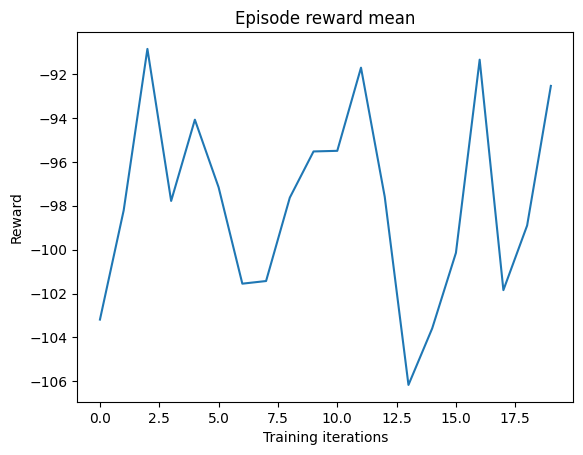

In [ ]:
plt.plot(episode_reward_mean_list)
plt.xlabel("Training iterations")
plt.ylabel("Reward")
plt.title("Episode reward mean")
plt.show()

## Render

If you are running this in a machine with GUI, you can render the trained policy by running:

```python
with torch.no_grad():
   env.rollout(
       max_steps=max_steps,
       policy=policy,
       callback=lambda env, _: env.render(),
       auto_cast_to_device=True,
       break_when_any_done=False,
   )
```
If you are running this in Google Colab, you can render the trained policy by running:

```bash
!apt-get update
!apt-get install -y x11-utils
!apt-get install -y xvfb
!pip install pyvirtualdisplay
```
```python
import pyvirtualdisplay
display = pyvirtualdisplay.Display(visible=False, size=(1400, 900))
display.start()
from PIL import Image

def rendering_callback(env, td):
    env.frames.append(Image.fromarray(env.render(mode="rgb_array")))
env.frames = []
with torch.no_grad():
   env.rollout(
       max_steps=max_steps,
       policy=policy,
       callback=rendering_callback,
       auto_cast_to_device=True,
       break_when_any_done=False,
   )
env.frames[0].save(
    f"{scenario_name}.gif",
    save_all=True,
    append_images=env.frames[1:],
   duration=3,
   loop=0,
)

from IPython.display import Image
Image(open(f"{scenario_name}.gif", "rb").read())
```


## Conclusion and next steps

In this tutorial, we have seen:

- How to create a multi-agent environment in TorchRL, how its specs work, and how it integrates with the library;
- How you use GPU vectorized environments in TorchRL;
- How to create different multi-agent network architectures in TorchRL (e.g., using parameter sharing, centralised critic)
- How we can use :class:`tensordict.TensorDict` to carry multi-agent data;
- How we can tie all the library components (collectors, modules, replay buffers, and losses) in a multi-agent MAPPO/IPPO training loop.

Now that you are proficient with multi-agent DDPG, you can check out all the TorchRL multi-agent implementations in the
GitHub repository.
These are code-only scripts of many popular MARL algorithms such as the ones seen in this tutorial,
QMIX, MADDPG, IQL, and many more!

You can also check out our other multi-agent tutorial on how to train competitive
MADDPG/IDDPG in PettingZoo/VMAS with multiple agent groups: :doc:`/tutorials/multiagent_competitive_ddpg`.

If you are interested in creating or wrapping your own multi-agent environments in TorchRL,
you can check out the dedicated
`doc section <MARL-environment-API>`.

Finally, you can modify the parameters of this tutorial to try many other configurations and scenarios
to become a MARL master.
Here are a few videos of some possible scenarios you can try in VMAS.

.. figure:: https://github.com/matteobettini/vmas-media/blob/main/media/vmas_scenarios_more.gif?raw=true
   :alt: VMAS scenarios

   Scenarios available in [VMAS](https://github.com/proroklab/VectorizedMultiAgentSimulator)_




In [ ]:
import torch

@torch.no_grad()
def evaluate_policy(env, policy, n_episodes=50, max_steps=500):
    """Returns: avg_episode_return, win_rate (win defined as episode_return > 0)."""
    done_keys = list(env.done_keys)
    def _done_score(k):
        s = 0
        ks = str(k).lower()
        if "done" in ks:
            s += 10
        if "terminated" in ks:
            s += 5
        if "truncated" in ks:
            s += 2
        return s
    done_key = sorted(done_keys, key=_done_score, reverse=True)[0]

    reward_key = env.reward_key

    returns = []
    wins = 0

    for _ in range(n_episodes):
        td = env.reset()
        ep_ret = 0.0

        for _t in range(max_steps):
            td = policy(td)
            td = env.step(td)

            if ("next", reward_key) in td.keys(True):
                r = td.get(("next", reward_key))
            elif ("next", "reward") in td.keys(True):
                r = td.get(("next", "reward"))
            else:
                r = td.get(reward_key) if reward_key in td.keys(True) else None
                if r is None:
                    raise KeyError(
                        f"Cannot find reward. reward_key={reward_key}. "
                        f"Available keys sample: {list(td.keys(True))[:40]}"
                    )

            ep_ret += r.float().mean().item()

            d = None
            if ("next", done_key) in td.keys(True):
                d = td.get(("next", done_key))
            elif done_key in td.keys(True):
                d = td.get(done_key)
            elif ("next", "done") in td.keys(True):
                d = td.get(("next", "done"))

            if d is not None and torch.as_tensor(d).any().item():
                break

        returns.append(ep_ret)
        if ep_ret > 0:
            wins += 1

    avg_ret = sum(returns) / len(returns)
    win_rate = wins / len(returns)

    print("Used done_key =", done_key)
    print("Used reward_key =", reward_key)
    return avg_ret, win_rate


# Example usage:
_eval_env = eval_env if "eval_env" in globals() else env
mappo_avg_ret, mappo_win = evaluate_policy(_eval_env, policy, n_episodes=50, max_steps=500)

print(f"[MAPPO] avg_episode_return = {mappo_avg_ret:.3f}")
print(f"[MAPPO] win_rate(episode_return>0) = {mappo_win:.2%}")


Used done_key = done
Used reward_key = ('agent_blue', 'reward')
[MAPPO] avg_episode_return = -10.675
[MAPPO] win_rate(episode_return>0) = 0.00%


In [15]:
rollout = env.rollout(n_rollout_steps)
print(rollout.keys(True))


_TensorDictKeysView(['done', 'terminated', ('agent_blue', 'observation'), ('agent_blue', 'info', 'sparse_reward'), ('agent_blue', 'info', 'ball_goal_pos_rew'), ('agent_blue', 'info', 'all_agent_ball_pos_rew'), ('agent_blue', 'info', 'ball_pos'), ('agent_blue', 'info', 'dist_ball_to_goal'), ('agent_blue', 'info', 'min_agent_dist_to_ball'), ('agent_blue', 'info', 'touching_ball'), ('agent_blue', 'info'), ('agent_blue', 'action'), 'agent_blue', ('next', 'done'), ('next', 'terminated'), ('next', 'agent_blue', 'observation'), ('next', 'agent_blue', 'reward'), ('next', 'agent_blue', 'info', 'sparse_reward'), ('next', 'agent_blue', 'info', 'ball_goal_pos_rew'), ('next', 'agent_blue', 'info', 'all_agent_ball_pos_rew'), ('next', 'agent_blue', 'info', 'ball_pos'), ('next', 'agent_blue', 'info', 'dist_ball_to_goal'), ('next', 'agent_blue', 'info', 'min_agent_dist_to_ball'), ('next', 'agent_blue', 'info', 'touching_ball'), ('next', 'agent_blue', 'info'), ('next', 'agent_blue'), 'next'],
    includ

In [23]:
def count_ball_touches(rollout, agent='agent_blue'):
    """
    统计每个agent触球的次数
    :param rollout: 环境返回的rollout数据
    :param agent: 指定agent名称，默认为'agent_blue'
    :return: 触球次数
    """
    touch_count = 0
    for t in rollout:
        # 获取触球状态
        touching_ball_tensor = t[(agent, 'info', 'touching_ball')]

        # 检查触球状态中是否有大于0的元素
        if torch.any(touching_ball_tensor > 0):  # 如果有触球
            touch_count += 1
    return touch_count

# 统计agent_blue触球次数
agent_blue_touch_count = count_ball_touches(rollout, 'agent_blue')
print(f"Agent Blue touched the ball {agent_blue_touch_count} times")

# 如果有多个代理（例如agent_red），可以类似方式进行统计
# 统计agent_red触球次数
# agent_red_touch_count = count_ball_touches(rollout, 'agent_red')
# print(f"Agent Red touched the ball {agent_red_touch_count} times")


Agent Blue touched the ball 0 times


In [24]:
import numpy as np

def compute_entropy(rollout, agent='agent_blue'):
    """
    计算触球状态的熵
    :param rollout: 环境返回的rollout数据
    :param agent: 指定agent名称，默认为'agent_blue'
    :return: 熵值
    """
    ball_touch_data = []
    for t in rollout:
        ball_touch_data.append(t[(agent, 'info', 'touching_ball')])  # 获取触球状态

    # 计算熵
    _, counts = np.unique(ball_touch_data, return_counts=True)
    prob = counts / len(ball_touch_data)
    entropy = -np.sum(prob * np.log(prob))  # 计算熵公式
    return entropy

# 计算熵
agent_blue_entropy = compute_entropy(rollout, 'agent_blue')
print(f"Agent Blue's entropy: {agent_blue_entropy}")

# 如果有多个代理（如agent_red），也可以计算它们的熵
# agent_red_entropy = compute_entropy(rollout, 'agent_red')
# print(f"Agent Red's entropy: {agent_red_entropy}")


Agent Blue's entropy: -40.62075301653315


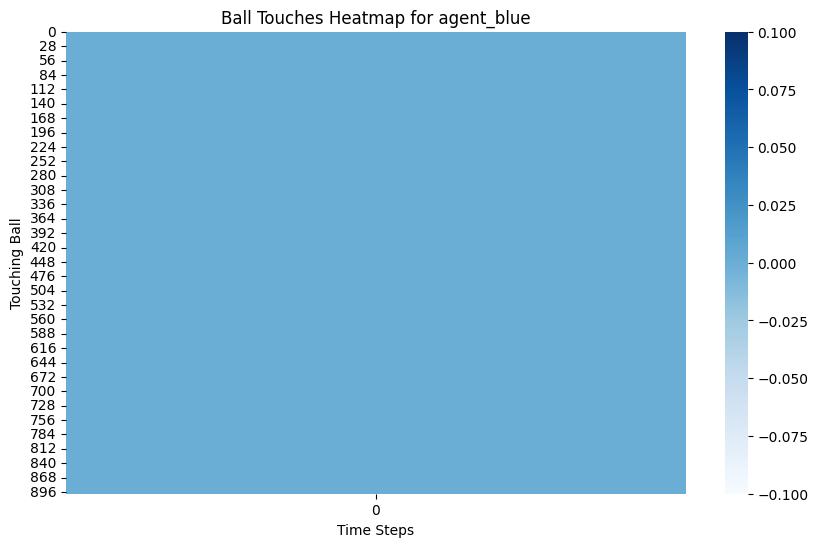

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

def create_heatmap(rollout, agent='agent_blue'):
    """
    创建触球的热图
    :param rollout: 环境返回的rollout数据
    :param agent: 指定agent名称，默认为'agent_blue'
    :return: 热图
    """
    ball_touch_data = []

    # 收集每个时间步的触球数据
    for t in rollout:
        touch_data = t[(agent, 'info', 'touching_ball')]  # 获取触球状态
        ball_touch_data.append(touch_data)

    # 绘制热图
    plt.figure(figsize=(10, 6))
    sns.heatmap(np.array(ball_touch_data).reshape(-1, 1), cmap='Blues', cbar=True)
    plt.title(f"Ball Touches Heatmap for {agent}")
    plt.xlabel('Time Steps')
    plt.ylabel('Touching Ball')
    plt.show()

# 创建触球热图
create_heatmap(rollout, 'agent_blue')


Agent Blue touched the ball 1 times
Agent Blue's entropy: 0.08476607571480994


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


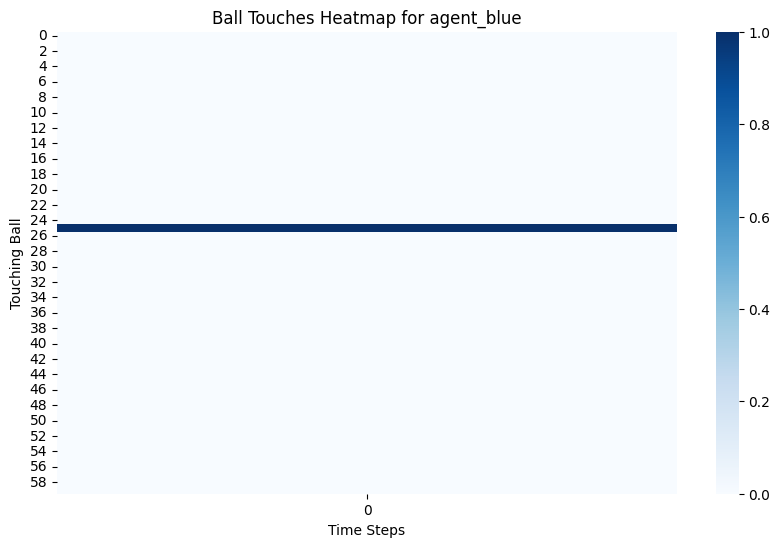

In [20]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 统计每个agent触球的次数
def count_ball_touches(rollout, agent='agent_blue', threshold=0.5):
    touch_count = 0
    for t in rollout:
        touching_ball_tensor = t[(agent, 'info', 'touching_ball')]

        # 如果是多维tensor，检查其中是否有大于阈值的元素
        if touching_ball_tensor.ndimension() > 1:  # 检查是不是多维tensor
            # 判断tensor中是否有任何元素大于阈值，表示触球
            if torch.any(touching_ball_tensor > threshold):
                touch_count += 1
        else:
            # 对于一维tensor，直接进行比较
            if touching_ball_tensor.item() > threshold:
                touch_count += 1
    return touch_count

# 计算熵
def compute_entropy(rollout, agent='agent_blue', threshold=0.5):
    ball_touch_data = []
    for t in rollout:
        # 获取触球状态
        touching_ball_tensor = t[(agent, 'info', 'touching_ball')]

        # 如果是多维tensor，检查其中是否有大于阈值的值
        if touching_ball_tensor.ndimension() > 1:  # 检查是不是多维tensor
            ball_touch_data.append(1 if torch.any(touching_ball_tensor > threshold) else 0)
        else:
            ball_touch_data.append(1 if touching_ball_tensor.item() > threshold else 0)

    # 计算熵
    _, counts = np.unique(ball_touch_data, return_counts=True)
    prob = counts / len(ball_touch_data)
    entropy = -np.sum(prob * np.log(prob))  # 熵公式
    return entropy

# 创建热图
def create_heatmap(rollout, agent='agent_blue', threshold=0.5):
    ball_touch_data = []
    for t in rollout:
        touch_data = t[(agent, 'info', 'touching_ball')]

        # 如果是多维tensor，检查其中是否有大于阈值的值
        if touch_data.ndimension() > 1:  # 检查是不是多维tensor
            ball_touch_data.append(1 if torch.any(touch_data > threshold) else 0)
        else:
            ball_touch_data.append(1 if touch_data.item() > threshold else 0)

    # 绘制热图
    plt.figure(figsize=(10, 6))
    sns.heatmap(np.array(ball_touch_data).reshape(-1, 1), cmap='Blues', cbar=True)
    plt.title(f"Ball Touches Heatmap for {agent}")
    plt.xlabel('Time Steps')
    plt.ylabel('Touching Ball')
    plt.show()

# 获取rollout数据
rollout = env.rollout(n_rollout_steps)

# 统计触球次数
agent_blue_touch_count = count_ball_touches(rollout, 'agent_blue')
print(f"Agent Blue touched the ball {agent_blue_touch_count} times")

# 计算熵
agent_blue_entropy = compute_entropy(rollout, 'agent_blue')
print(f"Agent Blue's entropy: {agent_blue_entropy}")

# 创建触球热图
create_heatmap(rollout, 'agent_blue')
